In [1]:
import os
import sys
import pandas as pd
import numpy as np
import sourmash
import screed
import time
import subprocess
import plotnine

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# model building package
import sklearn
from io import StringIO

## Iterate through chunked DIAMOND output of MMETSP against MMETSP
- find the sequences that have hits to other families at any level and categorize according to the family of the other match

In [2]:
input_tax="/vortexfs1/omics/alexander/akrinos/remodeling/EUKulele/databases/marmmetsp_better_diatom_taxonomy/tax-table.txt"
dir_in="../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/"
seqid = 65
tax_level = "family"
## evaluate process of clustering with tax coherence.
tax_table = pd.read_csv(input_tax,sep="\t")
tax_table.columns = [curr.lower() for curr in tax_table.columns]

tax_table["domain"] = [str(curr).strip() for curr in tax_table.domain]
tax_table["supergroup"] = [str(curr).strip() for curr in tax_table.supergroup]
tax_table["division"] = [str(curr).strip() for curr in tax_table.division]
tax_table["class"] = [str(curr).strip() for curr in tax_table["class"]]
tax_table["order"] = [str(curr).strip() for curr in tax_table.order]
tax_table["family"] = [str(curr).strip() for curr in tax_table.family]
tax_table["genus"] = [str(curr).strip() for curr in tax_table.genus]
tax_table["species"] = [str(curr).strip() for curr in tax_table.species]

## Select all Bacillariophyta families
list_fams = list(set(tax_table.loc[[(curr.strip()=="Bacillariophyta") for curr in tax_table["class"]],"family"])) #["Hemiaulaceae","Rhizosoleniaceae","Skeletonemataceae","Thalassiosiraceae"]
print(list_fams,flush=True)

## Iterate through families to identify hits in split fasta files
all_df=pd.DataFrame()
for current_fam in list_fams:
    ## This directory contains chunked BLAST output
    for curr in os.listdir(dir_in):
        input_small_file = os.path.join(dir_in,curr)
        fam_file = "fam_test_file.txt"
        #subprocess.Popen(["touch",fam_file])
        #subprocess.Popen(["rm",fam_file])
        ## Write file containing all of the MMETSP IDs that we're looking for
        filtered_tax = tax_table.loc[tax_table.family==current_fam,:]
        with open(fam_file,"w") as f:
            for mmetsp_id in list(filtered_tax.source_id):
                f.write(mmetsp_id)
                f.write("\n")
        #proc = subprocess.Popen(["cat", input_small_file, "| grep -f ", fam_file], stdout=subprocess.PIPE, shell=True)
        #(out, err) = proc.communicate()
        
        ## Grep all occurrences of that MMETSP in the chunked BLAST output
        output = subprocess.check_output(" ".join(["cat", input_small_file, "| rg -f ", fam_file]),
                                          shell=True).decode("utf-8").split("\n")
        print(input_small_file,current_fam,"ripgrep done",flush=True)
        TESTDATA = StringIO("\n".join(output))

        df = pd.read_csv(TESTDATA, sep="\t", header=None,names=["qseqid","sseqid","pident","length",
                                            "mismatch","gapopen","qstart","qend","sstart","send",
                                            "evalue","bitscore"])
        
        ## Filter hits by one direction rather than 2
        df = df.loc[[any([(curr2 in curr) for curr2 in list(filtered_tax.source_id)]) for curr in list(df.qseqid)],:]
        if len(df.index)==0:
            continue
        
        ## Get source ID from the opposite hit and merge with tax table to check if same family
        a = df.sseqid.str.split("_",expand=True)
        df["source_id"] = [col3 if (col1!=col1)|(col1 is None) else col1 if (col2!=col2)|(col2 is None) else col2 for col2,col1,col3 in zip(a.iloc[:,-1],a.iloc[:,-2],a.iloc[:,-3])]#a.iloc[:,-1]
        print(list(df["source_id"])[1:3],flush=True)
        df = df.merge(tax_table,how="left")
        df["MatchedFam"] = ["Yes" if curr==current_fam else "No" for curr in df["family"]]
        df["Family"] = current_fam
        
        ## Now we have the list of sequences and whether or not they contain a match
        all_df=pd.concat([all_df,df])

['Amphipleuraceae', 'Rhizosoleniaceae', 'Bacillariaceae', 'Coscinodiscaceae', 'Corethraceae', 'Chaetocerotales', 'Cyclophoraceae', 'Grammatophoraceae', 'Licmophoraceae', 'Stephanopyxidaceae', 'Lithodesmiaceae', 'Cymatosiraceae', 'Fragilariaceae', 'Thalassionemataceae', 'Leptocylindraceae', 'Naviculaceae', 'Skeletonemataceae', 'Hemiaulaceae', 'Catenulaceae', 'Odontellaceae', 'Triceratiaceae', 'Entomoneidaceae', 'Thalassiosiraceae', 'Stephanodiscaceae', 'Striatellaceae', 'Aulacoseiraceae', 'Stauroneidaceae', 'Staurosiraceae']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbj Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbv Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbas Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_lar

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbo Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbx Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbp Amphipleuraceae ripgrep done
['MMETSP0318', 'MMETSP1361']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbd Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaf Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbh Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbci Amphipleuraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matc

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbce Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbad Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcq Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbby Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbm Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbag Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcf Rhizosoleniaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger

['MMETSP0014', 'MMETSP0014']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaj Bacillariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbca Bacillariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbam Bacillariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcb Bacillariaceae ripgrep done
['MMETSP0329', 'MMETSP0139']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbb Bacillariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbal Bacillariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbao Bacillariaceae ripgrep done
../../../output/bidirectional-hit-dbs-m

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcg Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbu Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbch Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbar Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbt Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcj Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbak Coscinodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbah Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbe Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbg Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbat Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbq Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbs Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbai Corethraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcg Corethrace

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbw Chaetocerotales ripgrep done
['MMETSP0200', 'MMETSP0149']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaz Chaetocerotales ripgrep done
['MMETSP1336', 'MMETSP0717']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbay Chaetocerotales ripgrep done
['MMETSP0149', 'MMETSP0150']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbk Chaetocerotales ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbba Chaetocerotales ripgrep done
['MMETSP0752', 'MMETSP0753']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbap Chaetocerotales ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcr Cha

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbf Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbc Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbr Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbco Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcc Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbab Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbac Cyclophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-d

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbas Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbn Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcp Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbz Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbck Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcm Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcd Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbh Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbci Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcs Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcl Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaq Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dban Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaw Grammatophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbav Licmophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbl Licmophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbo Licmophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbx Licmophoraceae ripgrep done
['MMETSP1360', 'MMETSP1360']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbp Licmophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbd Licmophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaf Licmophoraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/sma

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbax Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbau Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbce Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbad Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcq Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbby Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbm Stephanopyxidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/smal

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaa Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaj Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbca Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbam Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcb Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbb Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbal Lithodesmiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcg Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbu Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbch Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbar Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbt Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcj Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbak Cymatosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-d

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcr Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbah Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbe Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbg Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbat Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbq Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbs Fragilariaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-d

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbae Thalassionemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbi Thalassionemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbw Thalassionemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaz Thalassionemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbay Thalassionemataceae ripgrep done
['MMETSP0156', 'MMETSP0158']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbk Thalassionemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbba Thalassionemataceae ripgrep done
../../../output/bidirectional-hit

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbck Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcm Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcd Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbf Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbc Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbr Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbco Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaq Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dban Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaw Leptocylindraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbj Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbv Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbas Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbn Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbd Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaf Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbh Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbci Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcs Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcl Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaq Naviculaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dban Naviculace

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbby Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbm Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbag Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcf Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbav Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbl Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbo Skeletonemataceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbal Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbao Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbax Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbau Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbce Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbad Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcq Hemiaulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbby Hemiaulace

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaa Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaj Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbca Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbam Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcb Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbb Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbal Catenulaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbao Catenulace

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbch Odontellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbar Odontellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbt Odontellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcj Odontellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbak Odontellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcn Odontellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaa Odontellaceae ripgrep done
['MMETSP0316', 'MMETSP0318']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_file

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbg Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbat Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbq Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbs Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbai Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcg Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbu Triceratiaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-d

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbay Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbk Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbba Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbap Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcr Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbah Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbe Entomoneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbco Thalassiosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcc Thalassiosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbab Thalassiosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbac Thalassiosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbae Thalassiosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbi Thalassiosiraceae ripgrep done
['MMETSP1416', 'MMETSP0880']
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbw Thalassiosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pe

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbv Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbas Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbn Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcp Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbz Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbck Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcm Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaf Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbh Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbci Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcs Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcl Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaq Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dban Stephanodiscaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcf Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbav Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbl Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbo Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbx Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbp Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbd Striatellaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-d

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbau Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbce Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbad Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcq Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbby Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbm Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbag Aulacoseiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaj Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbca Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbam Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcb Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbb Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbal Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbao Stauroneidaceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks

../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbch Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbar Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbbt Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcj Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbak Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbcn Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-dbaa Staurosiraceae ripgrep done
../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/hits-d

In [2]:
dir_in="../../../output/bidirectional-hit-dbs-modids/pep_diamond_matches/small_files_larger_chunks/"
li = []
save_suffix="100est_2Jan23_allfams_fast_new_test_train_25"
for curr in os.listdir(dir_in)[0:2]:
    df = pd.read_csv(os.path.join("../../scripts",'all_'+str(save_suffix)+"_"+curr+'.csv'),
                     usecols=["qseqid","sseqid","pident","bitscore","source_id",
                                                                     "source_id_q",
                                                        "family","Family","MatchedFam"],
                     dtype={"qseqid":str,"sseqid":str,
                            "pident":str,"bitscore":str,
                            "source_id":str,"source_id_q":str,"family":str,"Family":str,
                            "MatchedFam":str})
    df=df.loc[df.qseqid!=df.sseqid,:]
    li.append(df)

all_df = pd.concat(li, axis=0, ignore_index=True)
print("Dataframe concatenated",flush=True)

Dataframe concatenated


In [3]:
all_df.to_csv("all_df_3Jan23.csv")

In [2]:
all_df=pd.read_csv("all_df_3Jan23.csv")

## Count up our results with respect to family against other family
- We need to track which family was matched and then make our table of the proportion of that other family we had hits to.
- we track (1) total abundance of sequences in family and (2) number of references available for that family
- then we count # of hits to same family and hits to other families. we'll then organize this into a final table that we can use to train our ML model.

In [5]:
iterate_pidents=[80]
combined_frame = pd.DataFrame()
input_tax="/vortexfs1/omics/alexander/akrinos/remodeling/EUKulele/databases/marmmetsp_better_diatom_taxonomy/tax-table.txt"

tax_table = pd.read_csv(input_tax,sep="\t")
tax_table.columns = [curr.lower() for curr in tax_table.columns]

tax_table["domain"] = [str(curr).strip() for curr in tax_table.domain]
tax_table["supergroup"] = [str(curr).strip() for curr in tax_table.supergroup]
tax_table["division"] = [str(curr).strip() for curr in tax_table.division]
tax_table["class"] = [str(curr).strip() for curr in tax_table["class"]]
tax_table["order"] = [str(curr).strip() for curr in tax_table.order]
tax_table["family"] = [str(curr).strip() for curr in tax_table.family]
tax_table["genus"] = [str(curr).strip() for curr in tax_table.genus]
tax_table["species"] = [str(curr).strip() for curr in tax_table.species]
num_total = all_df.drop_duplicates(subset=["Family","qseqid"]).\
    groupby("Family")["qseqid"].count().reset_index().\
    rename({"qseqid":"Total_Number","Family":"family"},axis="columns")

num_families = tax_table.drop_duplicates(subset=["family","source_id"]).\
    groupby("family")["source_id"].count().reset_index().\
    rename({"source_id":"Num_References"},axis="columns")
all_df.pident=all_df.pident.astype(np.float16)
for pident in iterate_pidents:
    all_df_filt = all_df.drop_duplicates(subset=["Family","qseqid","sseqid","pident",
                                                 "MatchedFam"]).loc[all_df.pident >= pident,:]
    all_df_filt_2 = all_df_filt.loc[all_df_filt.qseqid!=all_df_filt.sseqid,:]
    all_df_filt_3a = all_df_filt_2.loc[all_df_filt_2.MatchedFam=="Yes",:]
    all_df_filt_3b = all_df_filt_2.loc[all_df_filt_2.MatchedFam=="No",:]
    counted_by_fam = all_df_filt_2.groupby(["qseqid","Family","family"])["sseqid"].count().reset_index()
    
    full_frame = counted_by_fam.merge(num_total,how="outer").merge(num_families,how="outer",
                                                                   left_on="family",right_on="family").fillna(0)
    full_frame["Pident"] = pident
    combined_frame = pd.concat([combined_frame,full_frame])

In [6]:
counted_by_fam = all_df_filt_2.groupby(["qseqid","Family","family"])["sseqid"].count().reset_index()
counted_by_fam.head()

,qseqid,Family,family,sseqid
0,CAMPEP_0113296918_MMETSP0010,Corethraceae,Corethraceae,1
1,CAMPEP_0113296934_MMETSP0010,Corethraceae,Corethraceae,1
2,CAMPEP_0113296936_MMETSP0010,Corethraceae,Corethraceae,3
3,CAMPEP_0113296942_MMETSP0010,Corethraceae,Corethraceae,2
4,CAMPEP_0113296944_MMETSP0010,Corethraceae,Corethraceae,1


In [6]:
combined_frame.head() #.loc[combined_frame.Family!=combined_frame.family,:].head(n=30)

,qseqid,Family,family,sseqid,Total_Number,Num_References,Pident
0,CAMPEP_0118797480_MMETSP1161,Chlorellales_X,Chlamydomonadales_X,2.0,6105.0,8,80
1,CAMPEP_0118797492_MMETSP1161,Chlorellales_X,Chlamydomonadales_X,4.0,6105.0,8,80
2,CAMPEP_0118797494_MMETSP1161,Chlorellales_X,Chlamydomonadales_X,1.0,6105.0,8,80
3,CAMPEP_0118797586_MMETSP1161,Chlorellales_X,Chlamydomonadales_X,7.0,6105.0,8,80
4,CAMPEP_0118797628_MMETSP1161,Chlorellales_X,Chlamydomonadales_X,1.0,6105.0,8,80


In [66]:
combined_frame.loc[(combined_frame.Family=="Chaetocerotales"),:]

,qseqid,Family,family,sseqid,Total_Number,Num_References,Pident
8101,CAMPEP_0119436562_MMETSP1336,Chaetocerotales,Corethraceae,2.0,60022.0,3,80
8102,CAMPEP_0119437018_MMETSP1336,Chaetocerotales,Corethraceae,1.0,60022.0,3,80
8103,CAMPEP_0119437636_MMETSP1336,Chaetocerotales,Corethraceae,2.0,60022.0,3,80
8104,CAMPEP_0119438646_MMETSP1336,Chaetocerotales,Corethraceae,1.0,60022.0,3,80
8105,CAMPEP_0119439798_MMETSP1336,Chaetocerotales,Corethraceae,2.0,60022.0,3,80
...,...,...,...,...,...,...,...
3169663,CAMPEP_0195469734_MMETSP0754,Chaetocerotales,Marinifilaceae,1.0,0.0,1,80
3169664,CAMPEP_0195492140_MMETSP0754,Chaetocerotales,Marinifilaceae,1.0,0.0,1,80
3169665,CAMPEP_0195452692_MMETSP0753,Chaetocerotales,Calditrichaceae,1.0,0.0,1,80
3169667,CAMPEP_0195498534_MMETSP0754,Chaetocerotales,Propionibacteriaceae,1.0,0.0,2,80


In [72]:
combined_frame_mod.loc[combined_frame_mod.qseqid=="CAMPEP_0119436228_MMETSP1336",:]

,qseqid,Family,family,sseqid,Total_Number,Num_References,Pident
37371,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Coscinodiscaceae,1.000000,23574.0,1,80
268001,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Chaetocerotales,0.600000,263230.0,20,80
485884,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Licmophoraceae,1.000000,19139.0,1,80
1510678,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Cymatosiraceae,0.428571,183018.0,7,80
2315788,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Kryptoperidiniaceae,0.166667,0.0,6,80
2354652,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Striatellaceae,1.000000,26270.0,1,80
2451041,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Bacillariaceae,0.142857,594590.0,28,80
3003832,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,Suessiaceae,0.047619,0.0,21,80


In [7]:
combined_frame_test=pd.read_csv("../../scripts/combined_frame_test_100est_26Dec22_allfams.csv")
combined_frame_train=pd.read_csv("../../scripts/combined_frame_train_100est_26Dec22_allfams.csv")

In [8]:
combined_frame_mod_test = combined_frame_test#.copy(deep=True)
combined_frame_mod_test["sseqid"] = combined_frame_mod_test["sseqid"] /combined_frame_mod_test["Num_References"]
pivoted_frame_test = combined_frame_mod_test.loc[combined_frame_mod_test.Family!=0,:].pivot_table(index=["qseqid","Family"],
                       columns=["family"],values="sseqid").reset_index().\
    fillna(0)

combined_frame_mod_train = combined_frame_train#.copy(deep=True)
combined_frame_mod_train["sseqid"] = combined_frame_mod_train["sseqid"] /combined_frame_mod_train["Num_References"]
pivoted_frame_train = combined_frame_mod_train.loc[combined_frame_mod_train.Family!=0,:].pivot_table(index=["qseqid","Family"],
                       columns=["family"],values="sseqid").reset_index().\
    fillna(0)

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 2689134088 cells in the resulting pandas object.


In [9]:
del combined_frame_mod_test
del combined_frame_mod_train
del all_df

In [11]:
# Labels are the values we want to predict
train_labels = np.array(pivoted_frame_train['Family'])
test_labels = np.array(pivoted_frame_test['Family'])
# Remove the labels from the features
# axis 1 refers to the columns
train_features= pivoted_frame_train.drop(['Family','qseqid'], axis = 1)
test_features= pivoted_frame_test.loc[:,pivoted_frame_train.columns].drop(['Family','qseqid'], axis = 1)
# Saving feature names for later use
feature_list = list(train_features.columns)
# Convert to numpy array
train_features = np.array(train_features)
test_features = np.array(test_features)

dt = pd.DataFrame({'FeatureNames':feature_list})
dt.to_csv("feature_names_" + save_suffix + ".csv")

NameError: name 'save_suffix' is not defined

In [12]:
save_suffix="100est_26Dec22_allfams"
dt.to_csv("feature_names_" + save_suffix + ".csv")
pivoted_frame_train.shape

(8509918, 318)

In [24]:
train_features = train_features.astype('float16')
test_features = test_features.astype('float16')

In [25]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
# Instantiate model with 1000 decision trees
rf = EasyEnsembleClassifier(n_estimators=100,random_state=42)#RandomForestClassifier(n_estimators = 16, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);
print("*************",flush=True)
print(rf.feature_names_in_,flush=True)

*************


AttributeError: 'EasyEnsembleClassifier' object has no attribute 'feature_names_in_'

In [26]:
import joblib
joblib.dump(rf, "./random_forest_"+ save_suffix + ".joblib")

['./random_forest_100est_26Dec22_allfams.joblib']

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = len([prediction for prediction,test_label in zip(predictions,test_labels) if prediction != test_label])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

In [75]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pivoted_frame.loc[pivoted_frame.Family=="Chaetocerotales",["qseqid","Family","Chaetocerotales"]]

family,qseqid,Family,Chaetocerotales
276843,CAMPEP_0119436228_MMETSP1336,Chaetocerotales,0.60
276844,CAMPEP_0119436234_MMETSP1336,Chaetocerotales,0.35
276845,CAMPEP_0119436238_MMETSP1336,Chaetocerotales,0.05
276846,CAMPEP_0119436248_MMETSP1336,Chaetocerotales,0.50
276847,CAMPEP_0119436260_MMETSP1336,Chaetocerotales,0.65
...,...,...,...
2441347,CAMPEP_0204652474_MMETSP0718,Chaetocerotales,0.05
2441348,CAMPEP_0204652476_MMETSP0718,Chaetocerotales,0.05
2441349,CAMPEP_0204652478_MMETSP0718,Chaetocerotales,0.05
2441350,CAMPEP_0204652480_MMETSP0718,Chaetocerotales,0.05


## later, we can use EUKulele annotations as baseline prediction

```
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))
Average baseline error:  5.06 degrees.
```

## for using the EUKulele annotations as the baseline prediction, we need to:
1. Take our train set, filter those labels, and create a custom EUKulele database
2. Take our test set, filter those labels, and create a sample file to test EUKulele with
3. Run EUKulele using the test set as the sample and the train set as our database

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 16, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
rf.get_params()


In [ ]:
joblib.dump(rf, "./random_forest_21Dec22.joblib")
#loaded_rf = joblib.load("./random_forest_21Dec22.joblib")

In [58]:
print(sklearn.__version__)
import importlib
importlib.reload(sklearn)

1.2.0


<module 'sklearn' from '/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/sklearn/__init__.py'>

In [ ]:
from sklearn import experimental
#importlib.reload(sklearn.model_selection)
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'max_depth': [20, 40, 80], # also tested 3,5
               'min_samples_split': [2, 5, 10, 20]}
sh = HalvingGridSearchCV(rf, param_grid, cv=5,
                          factor=2, resource='n_estimators',
                          max_resources=30).fit(train_features, train_labels)

sh.best_estimator_

In [21]:
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rf,param_grid,cv=5)
cv.fit(train_features,train_labels)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=40, n_estimators=16,
                                              random_state=42),
             param_grid={'max_depth': [3, 5, 10, 20, 40],
                         'min_samples_split': [2, 5, 10, 20]})

In [22]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
        
display(cv)

Best parameters are: {'max_depth': 40, 'min_samples_split': 2}


0.57 + or -0.064 for the {'max_depth': 3, 'min_samples_split': 2}
0.57 + or -0.064 for the {'max_depth': 3, 'min_samples_split': 5}
0.57 + or -0.064 for the {'max_depth': 3, 'min_samples_split': 10}
0.57 + or -0.064 for the {'max_depth': 3, 'min_samples_split': 20}
0.687 + or -0.034 for the {'max_depth': 5, 'min_samples_split': 2}
0.687 + or -0.034 for the {'max_depth': 5, 'min_samples_split': 5}
0.687 + or -0.034 for the {'max_depth': 5, 'min_samples_split': 10}
0.687 + or -0.034 for the {'max_depth': 5, 'min_samples_split': 20}
0.782 + or -0.01 for the {'max_depth': 10, 'min_samples_split': 2}
0.782 + or -0.01 for the {'max_depth': 10, 'min_samples_split': 5}
0.782 + or -0.01 for the {'max_depth': 10, 'min_samples_split': 10}
0.782 + or -0.01 for the {'max_depth': 10, 'min_samples_split': 20}
0.824 + or -0.002 for the {'max_depth': 20, 'min_samples_split': 2}
0.824 + or -0.002 for the {'max_depth': 20, 'min_samples_spli

In [15]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 40, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [16]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = len([prediction for prediction,test_label in zip(predictions,test_labels) if prediction != test_label])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 136733.0 degrees.


In [17]:
errors = len([prediction for prediction,test_label in zip(predictions,test_labels) if prediction != test_label])
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 136733.0 degrees.


In [18]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / len(test_labels))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.73 %.


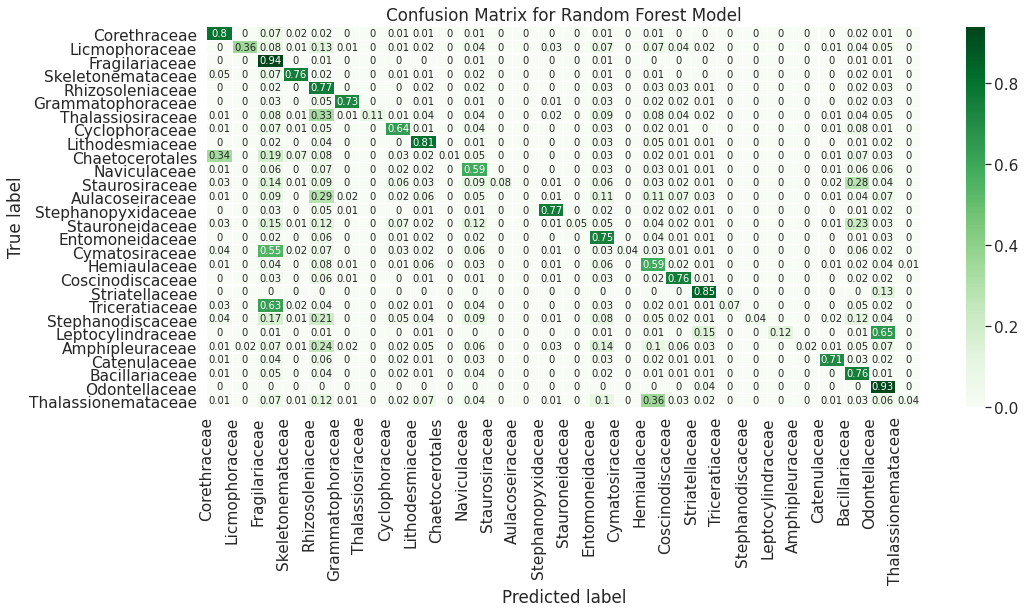

In [50]:
from sklearn.metrics import confusion_matrix
# Get and reshape confusion matrix data
matrix = confusion_matrix(test_labels, predictions)
matrix = np.round(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis],2)

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
tick_marks = np.arange(len(list(set(pivoted_frame["Family"]))))
tick_marks2 = tick_marks + 0.6
plt.xticks(tick_marks, list(set(pivoted_frame["Family"])), rotation=90)
plt.yticks(tick_marks2, list(set(pivoted_frame["Family"])), rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [52]:
pd.DataFrame(np.round(matrix.astype('float'),2),columns=list(set(pivoted_frame["Family"])),
             index=list(set(pivoted_frame["Family"])))

,Corethraceae,Licmophoraceae,Fragilariaceae,Skeletonemataceae,Rhizosoleniaceae,Grammatophoraceae,Thalassiosiraceae,Cyclophoraceae,Lithodesmiaceae,Chaetocerotales,...,Coscinodiscaceae,Striatellaceae,Triceratiaceae,Stephanodiscaceae,Leptocylindraceae,Amphipleuraceae,Catenulaceae,Bacillariaceae,Odontellaceae,Thalassionemataceae
Corethraceae,0.80,0.00,0.07,0.02,0.02,0.00,0.00,0.01,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00
Licmophoraceae,0.00,0.36,0.08,0.01,0.13,0.01,0.00,0.01,0.02,0.00,...,0.04,0.02,0.00,0.00,0.00,0.00,0.01,0.04,0.05,0.00
Fragilariaceae,0.00,0.00,0.94,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00
Skeletonemataceae,0.05,0.00,0.07,0.76,0.02,0.00,0.00,0.01,0.01,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00
Rhizosoleniaceae,0.00,0.00,0.02,0.00,0.77,0.00,0.00,0.00,0.02,0.00,...,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.03,0.00
Grammatophoraceae,0.00,0.00,0.03,0.00,0.05,0.73,0.00,0.00,0.01,0.00,...,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.02,0.03,0.00
Thalassiosiraceae,0.01,0.00,0.08,0.01,0.33,0.01,0.11,0.01,0.04,0.00,...,0.04,0.02,0.00,0.00,0.00,0.00,0.01,0.04,0.05,0.00
Cyclophoraceae,0.01,0.00,0.07,0.01,0.05,0.00,0.00,0.64,0.01,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.08,0.01,0.00
Lithodesmiaceae,0.00,0.00,0.02,0.00,0.04,0.00,0.00,0.00,0.81,0.00,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.02,0.00
Chaetocerotales,0.34,0.00,0.19,0.07,0.08,0.00,0.00,0.03,0.02,0.01,...,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.07,0.03,0.00


In [40]:
len(list(set(pivoted_frame["Family"])))

28